In [271]:
from IPython.display import Image
Image('binary_smoker.jpg')


FileNotFoundError: No such file or directory: 'binary_smoker.jpg'

FileNotFoundError: No such file or directory: 'binary_smoker.jpg'

<IPython.core.display.Image object>

**Это датасет по классификации пациентов на основе различных измерений (био-сигналов). Датасет размещен по ссылке:
https://www.kaggle.com/competitions/playground-series-s3e24/data**

С целями разработки проекта можно ознакомиться здесь (https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals), поскольку наш датасет был сформирован на основании вышеуказанного.

Так, составители датасета указали, что многие врачи прекратили консультирование пациентов по вопросу отказа от курения ввиду неэффективности. В частности, многие пациенты возвращались к вредной привычке, несмотря на врачебные предписания. Чтобы преодолеть эту проблему, было предложено обучить модель выявлять признаки, которые отличали бы курящих людей от некурящих, чтобы на основании этих признаков врачи имели возможность выявлять пациентов, которые имеют больше шансов бросить курить.

В датасете используются следующие признаки признаки: возраст, рост(см), вес(кг), талия(см), зрение(левый глаз и правый), слух (левое и право ухо), артериальное давление (верхнее систолическое и нижнее дистолическое), уровень сахара в крови натощак, холестерин (общий, а также LDL и HDL), триглицериды, гемоглобин, белок мочи, сывороточный креатинин, АСТ, АЛТ, ГТП(гамма-глутамилтранспептидаза), кариес зубов.

Целевой переменной является статус курения (0 - не курит, 1 - курит).


**В первую очередь обзорно исследуем датасет**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [3]:
df = pd.read_csv("train.csv", index_col='id') # Импорт датасета для обучения, столбец 'id' взят как индекс строк

In [6]:
print(df.info()) # В датасете 23 признака и таргетная переменна smoking

<class 'pandas.core.frame.DataFrame'>
Index: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin           1

In [8]:
print(df.describe()) 

                 age     height(cm)     weight(kg)      waist(cm)  \
count  159256.000000  159256.000000  159256.000000  159256.000000   
mean       44.306626     165.266929      67.143662      83.001990   
std        11.842286       8.818970      12.586198       8.957937   
min        20.000000     135.000000      30.000000      51.000000   
25%        40.000000     160.000000      60.000000      77.000000   
50%        40.000000     165.000000      65.000000      83.000000   
75%        55.000000     170.000000      75.000000      89.000000   
max        85.000000     190.000000     130.000000     127.000000   

       eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  \
count   159256.000000    159256.000000  159256.000000   159256.000000   
mean         1.005798         1.000989       1.023974        1.023421   
std          0.402113         0.392299       0.152969        0.151238   
min          0.100000         0.100000       1.000000        1.000000   
25%          

In [10]:
print(df.columns) 

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')


**Рассмотрим датафрейм на наличие нулевых значений и дубликатов**

In [13]:
def duplicates_nan(df, is_train=True):
    print(f'Количество признаков, содержащих пропущенные значения: {df.isnull().any().sum()}')
    print(f'Количество пропущенных значений: {df.isnull().values.sum()}')
    
    zero_rows = df[(df == 0).all(axis=1)]
    print(f'Количество нулевых строк: {zero_rows.shape[0]}')
    
    duplicates = df[df.duplicated()]
    print(f'Дубликаты: {duplicates}')
    
    df = df[~(df == 0).all(axis=1)]
    
    if df.isnull().values.sum() > 0: # если количество пропущенных значений больше 0
        df = df.dropna(how='any') # запускаем очистку пропущенных, возвращаем измененный датасет без пропусков.
    
    if df.duplicated().sum() > 0: # если количество дубликатов больше 0
        df = df.drop_duplicates(keep='first') # запускаем очистку дубликатов, оставляем первую строку в серии дубликатов (keep='first'), возвращаем измененный датасет без дубликатов (inplace=True).
    
    return df
df = duplicates_nan(df)

Количество признаков, содержащих пропущенные значения: 0
Количество пропущенных значений: 0
Количество нулевых строк: 0
Дубликаты: Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, smoking]
Index: []

[0 rows x 23 columns]


In [15]:
print(df.shape)

(159256, 23)


**Дубликаты и нулевые значения отсутствуют**

In [18]:
X_train =df.drop(columns = ['smoking'])
y_train = df['smoking']

**Разделим тренировочную выборку на признаки и целевую переменную**

**Посмотрим, какие значения наблюдаются в признаках**

In [22]:
X_train.head() # [159256 строк x 22 столбца]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,300,40,75,16.5,1,1.0,22,25,27,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,55,57,126,16.2,1,1.1,27,23,37,1
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,197,45,93,17.4,1,0.8,27,31,53,0
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,203,38,102,15.9,1,1.0,20,27,30,1
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,87,44,93,15.4,1,0.8,19,13,17,0


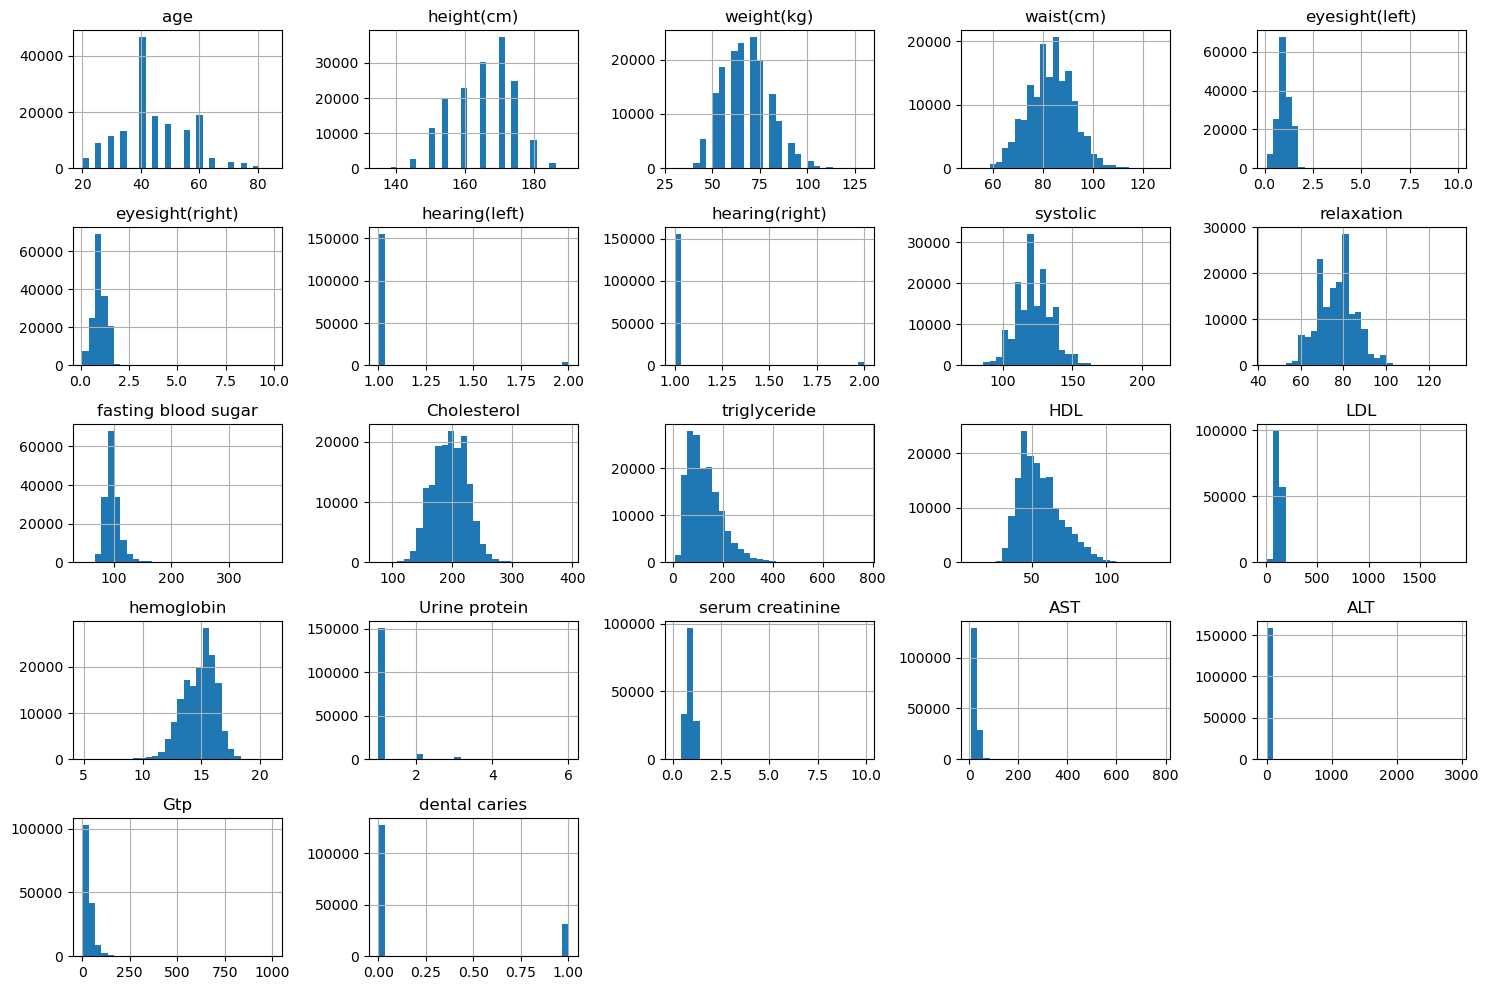

In [24]:
X_train.hist(bins=30, figsize=(15, 10))
plt.tight_layout() # подбирает оптимальное расположение подграфиков для достижения наиболее аккуратного отображения
None

**Мы обнаружили, что некоторые признаки имеют значения небольших натуральных чисел. Рассмотрим, какие значения встречаются по этим признакам, чтобы определить, имеют ли они бинарную структуру**

In [27]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
1    155438
2      3818
Name: count, dtype: int64
hearing(right)
1    155526
2      3730
Name: count, dtype: int64
Urine protein
1    150862
2      5609
3      2228
4       477
5        74
6         6
Name: count, dtype: int64
dental caries
0    127724
1     31532
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,300,40,75,16.5,1,1.0,22,25,27,0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,55,57,126,16.2,1,1.1,27,23,37,1
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,197,45,93,17.4,1,0.8,27,31,53,0
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,203,38,102,15.9,1,1.0,20,27,30,1
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,87,44,93,15.4,1,0.8,19,13,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,1,1,127,80,...,47,72,159,14.5,1,0.8,25,26,13,0
159252,50,155,75,82.0,1.0,1.0,1,1,120,80,...,202,64,108,14.5,1,0.6,21,20,18,0
159253,40,160,50,66.0,1.5,1.0,1,1,114,70,...,45,87,93,10.9,1,0.6,15,9,12,0


**Таким образом, слух и кариес являются в сущности, закодированными бинарными категориальными переменными**. 

В то же время, наблюдается некоторое неединообразие, поскольку разделение в столбцах со слухом произведено по принципу 1/2, а не 0/1, как в столбце "кариес" или "курение". Поэтому было принято решение изменить кодировку на 0/1.

**Кроме того, столбец с содержанием белка в моче содержит некую градацию содержания от 1 до 6, что также указывает на то, что переменная является категориальной.**

Мы исходим из того, что 1 - это либо абсолютное, либо относительное отсутствие белка в моче (обнаружено клинически незначимое количество). Таким образом, представляется целесообразной перекодировка этого столбца на диапазон 0-5.

Перекодировка в данном случае требуется для стабильности предсказаний модели, поскольку различия в принципах классификации могут привести к ухудшениям качества модели.

**Произведем перекодировку вышеуказанных признаков**

In [31]:
columns_recoding = ['hearing(left)', 'hearing(right)', 'Urine protein']
def recoding(dataframe, is_train=True):
    for column in columns_recoding:
        dataframe[column] = dataframe[column] - 1
    return dataframe
X_train = recoding(X_train)
    

In [33]:
columns_un_values = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']
def check_unique(dataframe):
    for column in columns_un_values:
        print(dataframe[column].value_counts())
     
print(check_unique(X_train))
X_train

hearing(left)
0    155438
1      3818
Name: count, dtype: int64
hearing(right)
0    155526
1      3730
Name: count, dtype: int64
Urine protein
0    150862
1      5609
2      2228
3       477
4        74
5         6
Name: count, dtype: int64
dental caries
0    127724
1     31532
Name: count, dtype: int64
None


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,0,0,135,87,...,300,40,75,16.5,0,1.0,22,25,27,0
1,70,165,65,89.0,0.6,0.7,1,1,146,83,...,55,57,126,16.2,0,1.1,27,23,37,1
2,20,170,75,81.0,0.4,0.5,0,0,118,75,...,197,45,93,17.4,0,0.8,27,31,53,0
3,35,180,95,105.0,1.5,1.2,0,0,131,88,...,203,38,102,15.9,0,1.0,20,27,30,1
4,30,165,60,80.5,1.5,1.0,0,0,121,76,...,87,44,93,15.4,0,0.8,19,13,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,40,155,45,69.0,1.5,2.0,0,0,127,80,...,47,72,159,14.5,0,0.8,25,26,13,0
159252,50,155,75,82.0,1.0,1.0,0,0,120,80,...,202,64,108,14.5,0,0.6,21,20,18,0
159253,40,160,50,66.0,1.5,1.0,0,0,114,70,...,45,87,93,10.9,0,0.6,15,9,12,0


**Перекодирование успешно произведено**

**Далее посмотрим, имеются ли выбросы**

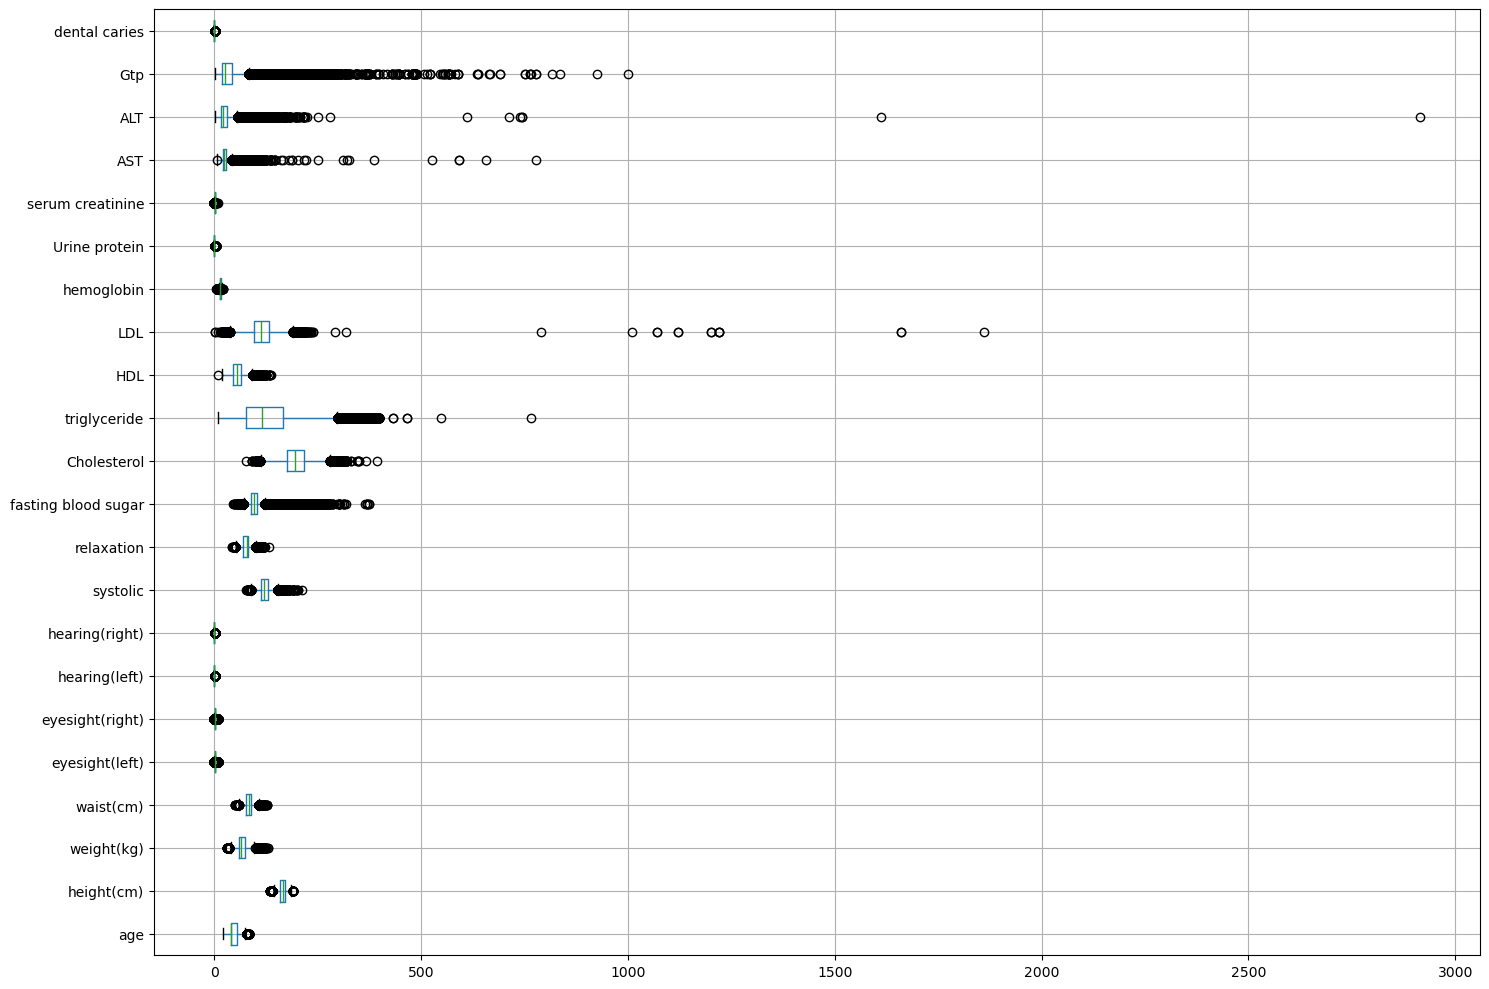

In [37]:
X_train.boxplot(figsize=(15, 10), vert=False) # Обнаружение выбросов
plt.tight_layout()

**Произведение логарифмирование признаков с выбросами**

In [40]:
print(X_train.columns)

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')


        age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
id                                                               
0        55         165          60       81.0             0.5   
1        70         165          65       89.0             0.6   
2        20         170          75       81.0             0.4   
3        35         180          95      105.0             1.5   
4        30         165          60       80.5             1.5   
...     ...         ...         ...        ...             ...   
159251   40         155          45       69.0             1.5   
159252   50         155          75       82.0             1.0   
159253   40         160          50       66.0             1.5   
159254   50         165          75       92.0             1.2   
159255   40         145          45       76.4             1.0   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
id                                                           

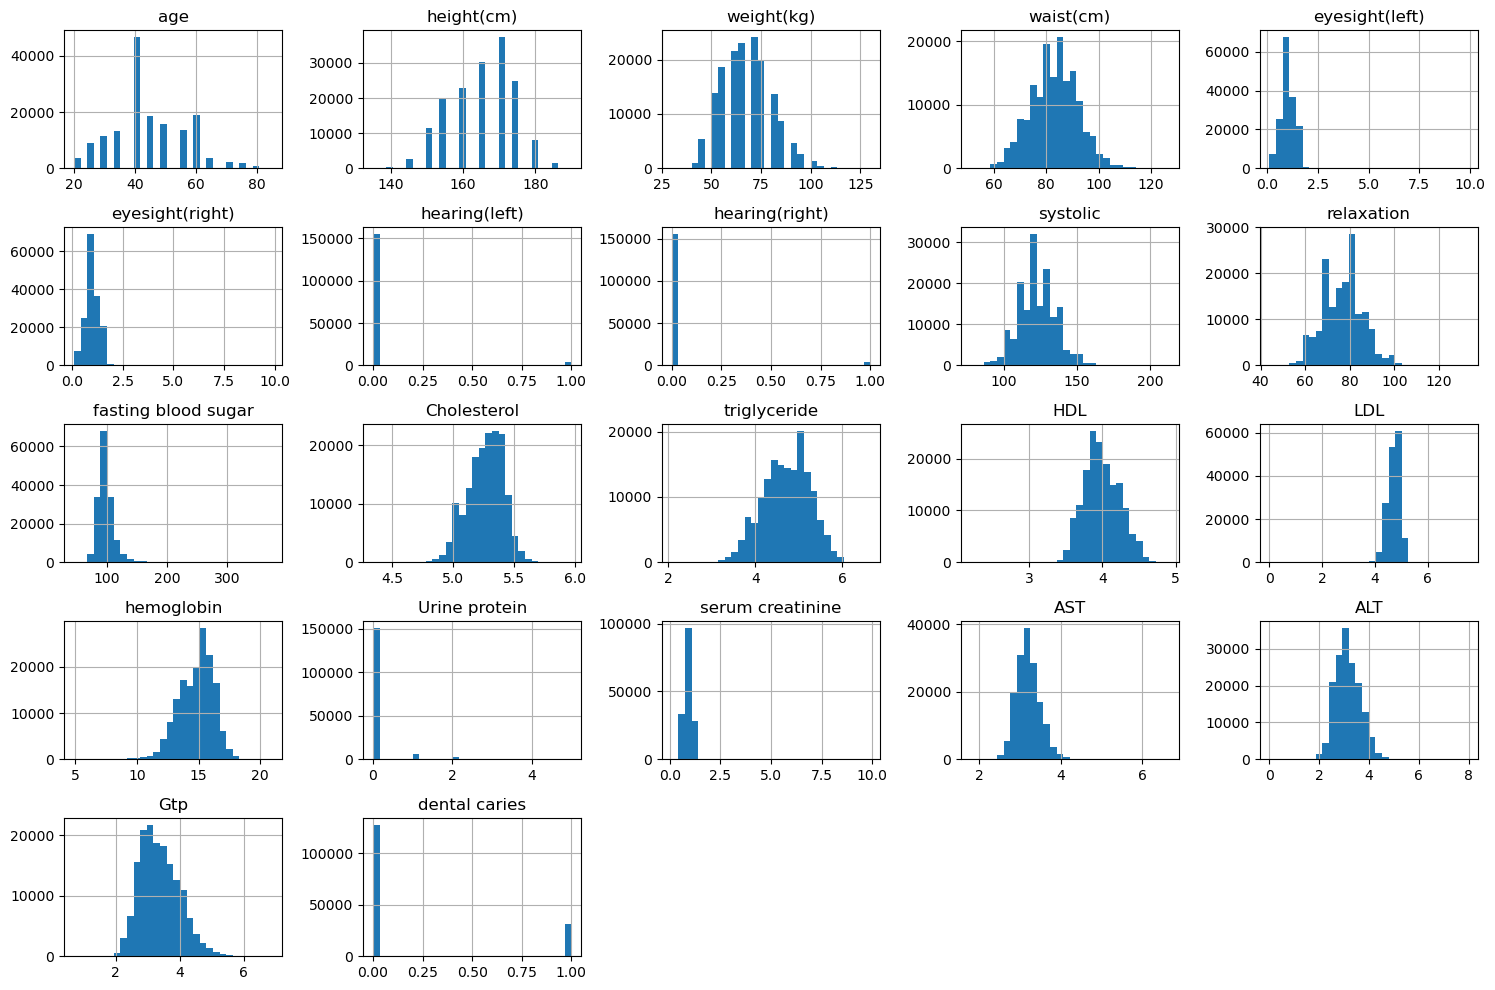

In [42]:
columns_log = ['Cholesterol','triglyceride', 'LDL', 'HDL', 'AST', 'ALT', 'Gtp'] # Находим признаки с большими выбросами, добавляем в переменную
def log_func(dataframe):
    dataframe[columns_log] = dataframe[columns_log].map(lambda x: x if x > 0 else 1) # Логарифмируем признаки с большими выбросами
    dataframe[columns_log] = np.log(dataframe[columns_log])
    dataframe.hist(bins=30, figsize=(15, 10)) # Строим гистограмму
    plt.tight_layout()
    None
    #plt.savefig('g.png')
    return dataframe

print(log_func(X_train))

**Видим, что распределение признаков стало нормальным, более приближенным к колоколообразной форме**

**Далее стандартизируем значения числовых переменных**

In [46]:
columns_scale = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
       'ALT', 'Gtp']


In [48]:
scaler = StandardScaler()
X_train[columns_scale] = scaler.fit_transform(X_train[columns_scale])
X_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
0,0.902985,-0.030268,-0.567581,-0.223489,-1.257856,-1.022156,0,0,0.981702,1.125777,...,1.861115,-1.252796,-1.653653,1.189928,0,0.597927,-0.338123,0.143437,-0.121179,0
1,2.169636,-0.030268,-0.170319,0.669577,-1.009169,-0.767247,1,1,1.845852,0.681066,...,-1.328790,0.206753,0.511858,0.980315,0,1.155511,0.350584,-0.024532,0.384063,1
2,-2.052535,0.536694,0.624205,-0.223489,-1.506543,-1.277064,0,0,-0.353802,-0.208355,...,1.070283,-0.767410,-0.755751,1.818767,0,-0.517239,0.350584,0.576769,0.960330,0
3,-0.785883,1.670617,2.213252,2.455708,1.229017,0.507296,0,0,0.667465,1.236955,...,1.126697,-1.464177,-0.370173,0.770702,0,0.597927,-0.658643,0.298471,0.047770,1
4,-1.208100,-0.030268,-0.567581,-0.279305,1.229017,-0.002521,0,0,-0.118125,-0.097177,...,-0.466513,-0.860021,-0.755751,0.421347,0,-0.517239,-0.831138,-1.173870,-0.863009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,-0.363666,-1.164191,-1.759366,-1.563087,1.229017,2.546566,0,0,0.353229,0.347533,...,-1.624353,1.169484,1.482853,-0.207493,0,-0.517239,0.091771,0.222445,-1.293178,0
159252,0.480768,-1.164191,0.624205,-0.111855,-0.014419,-0.002521,0,0,-0.196684,0.347533,...,1.117412,0.684098,-0.131586,-0.207493,0,-1.632406,-0.494566,-0.306076,-0.771354,0
159253,-0.363666,-0.597229,-1.362104,-1.897986,1.229017,-0.002521,0,0,-0.668039,-0.764243,...,-1.706120,1.949354,-0.755751,-2.722849,0,-1.632406,-1.626094,-1.914635,-1.421529,0


**Таким образом, датасет предобработан, готов к анализу и построению модели**

**На данном этапе мы приняли решение о предобработке тестовой выборки, чтобы убедиться, что все функции работают исправно**

In [52]:
df_test = pd.read_csv("test.csv", index_col='id')
print(df_test.columns)
print(df_test.shape) 

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')
(106171, 22)


**Убедились, что все столбцы из тренировочной выборки присутствуют (за исключением таргетной переменной). Далее запустим ранее сформированные функции для предобработки датасета**

Количество признаков, содержащих пропущенные значения: 0
Количество пропущенных значений: 0
Количество нулевых строк: 0
Дубликаты: Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries]
Index: []

[0 rows x 22 columns]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
159256,-0.363666,-0.030268,0.226943,0.111411,0.482955,0.507296,0,0,0.588906,1.348132,...,0.962244,-0.416473,0.130553,-0.417106,0,0.040344,-0.831138,0.143437,0.151259,0
159257,3.014071,-0.597229,-0.567581,1.116110,-0.014419,-0.002521,1,1,1.688733,-0.541888,...,0.655463,-1.803081,-0.289119,-1.255558,0,1.155511,-0.658643,-1.335112,-0.310047,0
159258,1.325202,0.536694,0.226943,0.390494,-1.009169,-0.767247,0,0,-0.432361,-0.208355,...,0.826004,-1.357131,-0.986424,0.421347,0,2.828261,1.499859,1.907030,0.340128,0
159259,-0.363666,-0.597229,-1.362104,-1.786353,-1.755231,-1.531973,0,0,-0.510921,-1.653664,...,-1.624353,1.337712,0.577594,-0.207493,0,-1.632406,0.091771,-0.518321,-1.713887,1
159260,-0.363666,0.536694,0.624205,0.714230,-0.014419,-0.257430,0,0,0.746025,1.904021,...,-0.204652,-1.357131,0.411272,1.189928,0,0.597927,0.704903,1.039237,-0.121179,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265422,-0.363666,-0.030268,-0.567581,-0.558388,-0.511794,-0.257430,0,0,-0.825157,0.125178,...,-0.577808,0.348871,1.211710,1.120057,0,1.155511,-0.045510,0.576769,-0.062862,0
265423,-0.363666,0.536694,1.418728,1.339376,0.482955,0.507296,0,0,0.588906,1.459310,...,0.962244,-0.860021,-0.452831,0.840573,1,0.597927,0.091771,0.576769,0.426826,0
265424,-0.785883,0.536694,1.418728,0.669577,0.482955,0.507296,0,0,0.667465,1.014599,...,-0.720687,-0.093090,1.010855,0.770702,0,-0.517239,1.025424,0.640725,-0.310047,1


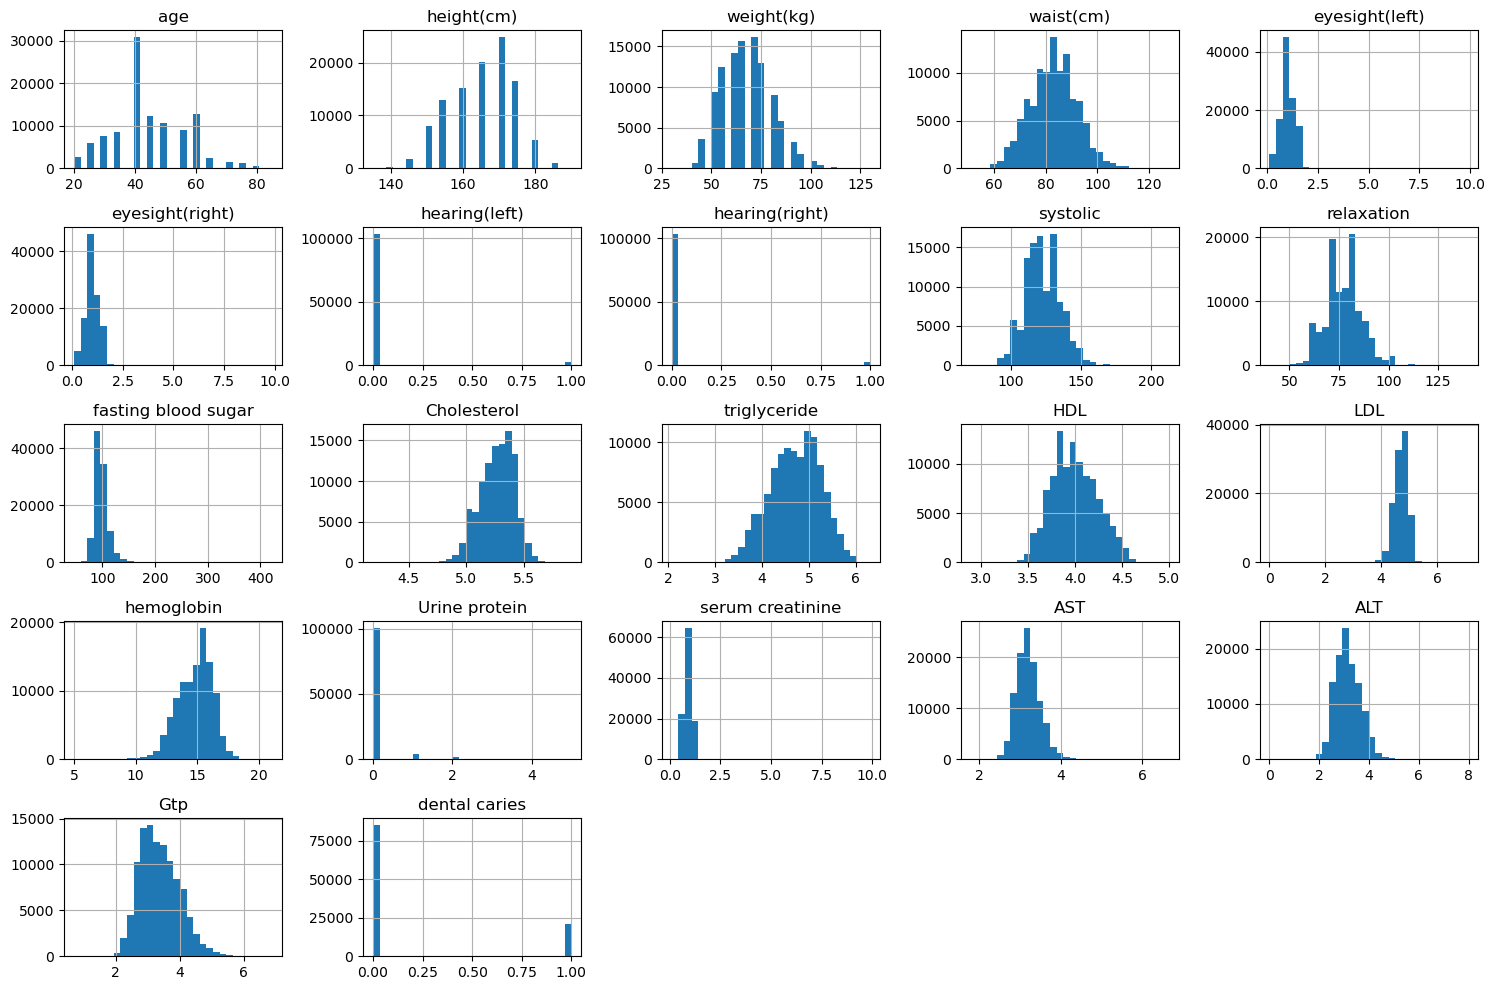

In [55]:
X_test = duplicates_nan(df_test)
X_test = recoding(X_test)
X_test = log_func(X_test)
X_test[columns_scale] = scaler.transform(X_test[columns_scale])
X_test

**На данном этапе мы завершили преобработку тестовой выборки и перешли к созданию модели, ее обучению и предсказаниям**

In [58]:
model = LogisticRegression(solver='liblinear', random_state=42)

In [60]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

**Оценим качество предсказания на тренировочной выборке**

In [63]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7573843371678304
Precision: 0.7115187887881061
Recall: 0.7489268229652707
F1 Score: 0.7297437188741537
ROC AUC: 0.8415686854211142


**Модель демонстрирует среднее качество. Мы использовали кросс-валидацию для отбора лучших параметров модели. Между тем, на данном этапе модель с другими параметрами не продемонстрировала ощутимого улучшения метрик (все улучшения были в масштабе 0.01%), поэтому тонкая настройка была исключена из настоящего файла, и за стандартную модель была выбрана текущая дефолтная модель**

**В то же время, полагаем целесообразным произвести инжиниринг признаков для возможного улучшения качества модели**

In [67]:
#import pandas as pd
#from scipy.stats import ttest_ind
#
#num_columns = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
#       'eyesight(right)', 'systolic',
#       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
#       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
#       'ALT', 'Gtp']
#
#alpha = 0.01  # Уровень значимости
#
df_united_test = X_train.copy()
df_united_test['smoking'] = y_train.reset_index(drop=True)
print(df_united_test['smoking'].head())
#
#
#relevant_features = []
#non_relevant_features = []
#
## Перебираем все числовые признаки в датасете (кроме целевой переменной)
#for column in num_columns:
#    if column != 'smoking':  # Целевая переменная
#        # Разделяем данные на две группы по значению целевой переменной
#        group1 = df_united_test[df_united_test['smoking'] == 0][column]  # Не курит
#        group2 = df_united_test[df_united_test['smoking'] == 1][column]  # Курит
#        print(len(group1), len(group2))
#
#        # Выполняем t-тест
#        t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
#
#        # Проверяем p-значение для отбора признаков
#        if p_value < alpha:
#            relevant_features.append(column)
#        else:
#            non_relevant_features.append(column)
#
## Вывод результатов
#print("Релевантные признаки:", relevant_features)
#print("Нерелевантные признаки:", non_relevant_features)


id
0    1
1    0
2    1
3    0
4    1
Name: smoking, dtype: int64


Выведем тепловую карту корреляций чтобы проверить, какие признаки имеют высокую степень корреляции:

<Axes: >

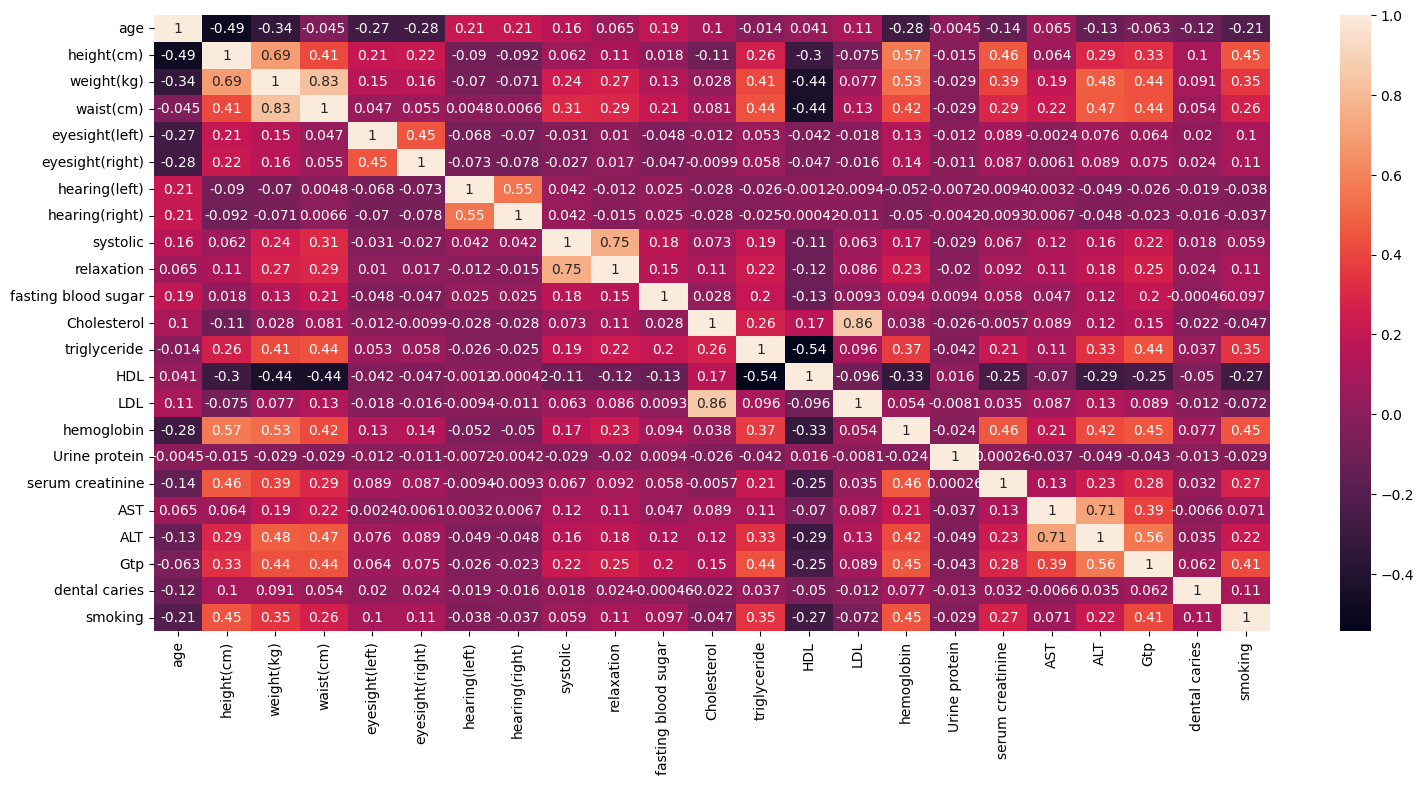

In [296]:
plt.figure(figsize=(18,8))
sns.heatmap(df_united_test.corr(), annot=True)

Добавим полиномиальные признаки на основе исходных данных:
- индекс массы тела;
- соотношение обхвата талии к росту;
- общий признак для зрения;
- сооотношение уровня холестерина (холестерин ЛПВП к холестерину ЛПНП).

In [297]:
df_new_features = df.copy()
df_new_features = df_new_features.drop(columns = ['smoking'])

df_new_features['BMI'] = df_new_features['weight(kg)'] / ((df_new_features['height(cm)'] / 100) **2)
df_new_features['waist_height_ratio'] = df_new_features['waist(cm)'] / df_new_features['height(cm)']
df_new_features['eyesight'] = (df_new_features['eyesight(left)'] + df_new_features['eyesight(right)']) / 2
df_new_features['chol_ratio'] = df_new_features['LDL'] / df_new_features['HDL']


Проверим полученные значения:

In [298]:
print(df_new_features[['BMI', 'waist_height_ratio', 'eyesight', 'chol_ratio']].describe()) #проверим полученные значения
print(df_new_features.head(10))

                 BMI  waist_height_ratio       eyesight     chol_ratio
count  159256.000000       159256.000000  159256.000000  159256.000000
mean       24.452825            0.502491       1.003394       2.183459
std         3.368651            0.050137       0.338095       0.750977
min        11.718750            0.300000       0.100000       0.021739
25%        22.222222            0.468571       0.800000       1.653061
50%        24.221453            0.500000       1.000000       2.142857
75%        26.159334            0.535172       1.200000       2.660714
max        45.785640            0.793750       9.900000      39.574468
    age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
id                                                                            
0    55         165          60       81.0             0.5              0.6   
1    70         165          65       89.0             0.6              0.7   
2    20         170          75       81.0   

Проведем обработку новых и старых признаков

Количество признаков, содержащих пропущенные значения: 0
Количество пропущенных значений: 0
Количество нулевых строк: 0
Дубликаты: Empty DataFrame
Columns: [age, height(cm), weight(kg), waist(cm), eyesight(left), eyesight(right), hearing(left), hearing(right), systolic, relaxation, fasting blood sugar, Cholesterol, triglyceride, HDL, LDL, hemoglobin, Urine protein, serum creatinine, AST, ALT, Gtp, dental caries, BMI, waist_height_ratio, eyesight, chol_ratio]
Index: []

[0 rows x 26 columns]


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,waist_height_ratio,eyesight,chol_ratio
count,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,159256.000000,159256.000000,1.592560e+05,1.592560e+05,...,159256.000000,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05,159256.000000,1.592560e+05,1.592560e+05,1.592560e+05,1.592560e+05
mean,2.248666e-17,9.160414e-16,-4.986774e-16,-2.951820e-16,2.627905e-16,1.983198e-16,0.023974,0.023421,4.933680e-16,-6.715659e-16,...,0.074233,-2.696614e-16,-4.697325e-16,1.094618e-15,1.016361e-15,0.197996,-3.198103e-16,-1.909581e-16,7.807868e-18,5.157654e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.152969,0.151238,1.000003e+00,1.000003e+00,...,0.347856,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.398490,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.052535e+00,-3.432036e+00,-2.951152e+00,-3.572484e+00,-2.252605e+00,-2.296699e+00,0.000000,0.000000,-3.574724e+00,-3.654862e+00,...,0.000000,-4.420323e+00,-4.707505e+00,-6.340848e+00,-4.294667e+00,0.000000,-3.780182e+00,-4.038766e+00,-2.672019e+00,-2.878551e+00
25%,-3.636662e-01,-5.972291e-01,-5.675808e-01,-6.700213e-01,-5.117941e-01,-5.123383e-01,0.000000,0.000000,-6.680387e-01,-7.642430e-01,...,0.000000,-5.172393e-01,-6.586429e-01,-7.555893e-01,-7.713537e-01,0.000000,-6.621671e-01,-6.765369e-01,-6.015888e-01,-7.062790e-01
50%,-3.636662e-01,-3.026766e-02,-1.703190e-01,-2.221364e-04,-1.441942e-02,-2.520980e-03,0.000000,0.000000,-1.181252e-01,1.251782e-01,...,0.000000,4.034405e-02,-4.551037e-02,-1.140782e-01,-1.211786e-01,0.000000,-6.868401e-02,-4.968058e-02,-1.003742e-02,-5.406554e-02
75%,9.029851e-01,5.366938e-01,6.242046e-01,6.695770e-01,4.829553e-01,5.072964e-01,0.000000,0.000000,5.889064e-01,5.698888e-01,...,0.000000,5.979274e-01,5.908951e-01,6.407254e-01,6.619092e-01,0.000000,5.065869e-01,6.518483e-01,5.815140e-01,6.355143e-01
max,3.436288e+00,2.804539e+00,4.994084e+00,4.911638e+00,2.211875e+01,2.268435e+01,1.000000,1.000000,7.109309e+00,6.239949e+00,...,5.000000,5.022284e+01,1.165298e+01,9.729038e+00,5.669033e+00,1.000000,6.332767e+00,5.809289e+00,2.631400e+01,4.978996e+01


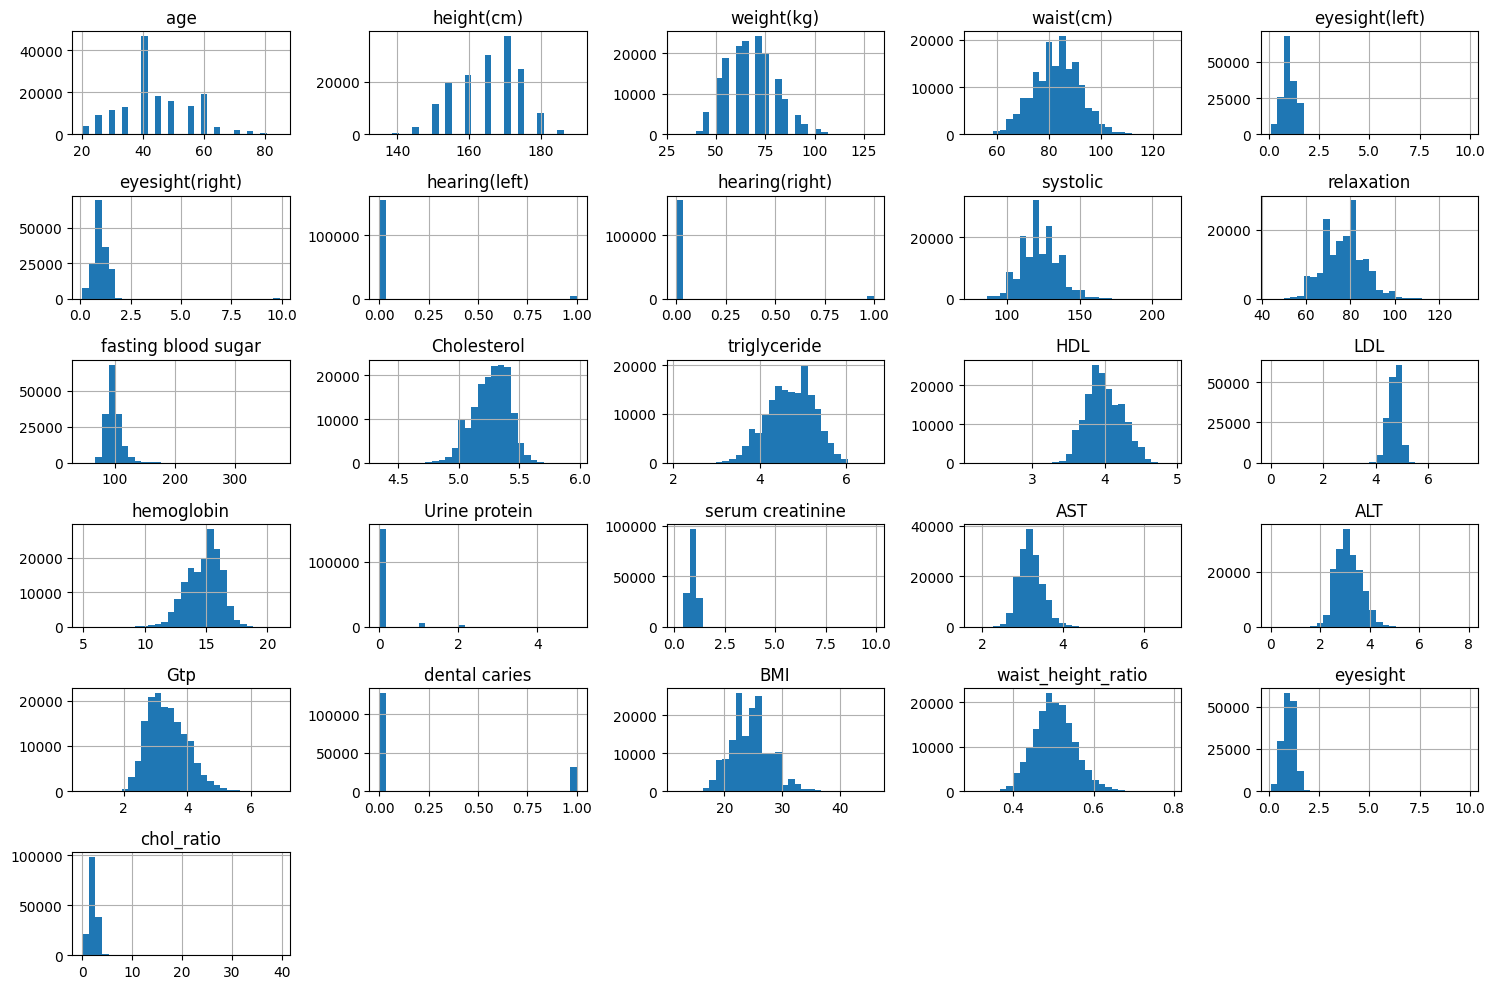

In [299]:
columns_scale = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight', 'eyesight(left)', 'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'BMI', 'waist_height_ratio', 'chol_ratio']


df_new_features = duplicates_nan(df_new_features)
df_new_features = recoding(df_new_features)
df_new_features = log_func(df_new_features)

scaler.fit(df_new_features[columns_scale])
df_new_features[columns_scale] = scaler.transform(df_new_features[columns_scale])

df_new_features.describe()

Составим рейтинг наиболее значимых признаков по ANOVA

In [300]:
from sklearn.feature_selection import SelectKBest, f_classif

bestfeature = SelectKBest()
bestfeature.fit(df_new_features, y_train)
sc = bestfeature.scores_
impt_feature = pd.DataFrame({"Feature":df_new_features.columns,"Score":sc})
impt_feature = impt_feature.sort_values(by="Score",ascending=False)
print(impt_feature)


                Feature         Score
15           hemoglobin  40590.708903
1            height(cm)  39790.683120
20                  Gtp  32088.754804
2            weight(kg)  22486.078271
12         triglyceride  21725.158797
13                  HDL  12881.563528
17     serum creatinine  12822.695823
3             waist(cm)  11806.430639
19                  ALT   8238.777835
0                   age   7059.957676
22                  BMI   3264.265703
25           chol_ratio   3058.352866
24             eyesight   2462.854039
5       eyesight(right)   1942.728630
9            relaxation   1932.704519
21        dental caries   1831.752533
4        eyesight(left)   1622.289991
10  fasting blood sugar   1498.031452
14                  LDL    823.796239
18                  AST    806.924654
8              systolic    549.540128
11          Cholesterol    356.283083
23   waist_height_ratio    296.220227
6         hearing(left)    232.959894
7        hearing(right)    216.638889
16        Ur

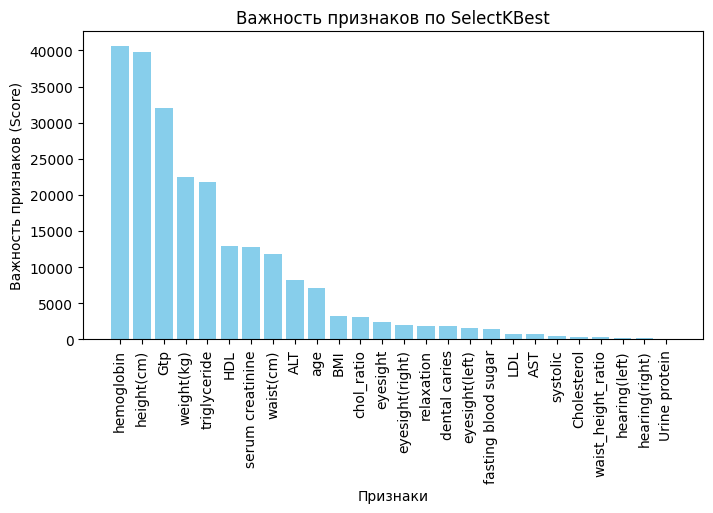

In [301]:
plt.figure(figsize=(8, 4))
plt.bar(impt_feature["Feature"], impt_feature["Score"], color="skyblue")

plt.xticks(rotation=90)
plt.xlabel("Признаки")
plt.ylabel("Важность признаков (Score)")
plt.title("Важность признаков по SelectKBest")

# Отображаем диаграмму
plt.show()

Отберем 18 наиболее значимых признаков

In [302]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=18)
selector.fit(X_train, y_train)

# Получаем масив индексов выбранных признаков
selected_columns = X_train.columns[selector.get_support()]

# Создаем новый DataFrame с отобранными признаками
X_selected = X_train[selected_columns]

print(X_selected.head(10))

         age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
id                                                                
0   0.902985   -0.030268   -0.567581  -0.223489       -1.257856   
1   2.169636   -0.030268   -0.170319   0.669577       -1.009169   
2  -2.052535    0.536694    0.624205  -0.223489       -1.506543   
3  -0.785883    1.670617    2.213252   2.455708        1.229017   
4  -1.208100   -0.030268   -0.567581  -0.279305        1.229017   
5   0.480768    0.536694   -0.964843  -3.572484        0.482955   
6   0.058551   -0.597229   -0.964843  -1.563087        1.229017   
7   0.902985   -1.164191   -0.567581   0.167228       -0.760481   
8  -0.363666   -0.030268    0.226943   0.669577       -0.760481   
9  -0.363666   -1.164191   -1.362104  -1.116554        1.229017   

    eyesight(right)  systolic  relaxation  fasting blood sugar  triglyceride  \
id                                                                             
0         -1.022156  0.981702    1.

**Дополнительное исследование от аналитика**

Наш аналитик исследовал возможные направления применения данного датасета:
1. Здравоохранение и профилактика:
   - Идентификация курильщиков: использование датасета для выявления курильщиков среди пациентов (это может помочь врачам в предоставлении более целенаправленных и персонализированных рекомендаций для лечения, направленного на отказ от курения).
   - Мониторинг здоровья: слежение за состоянием здоровья пациентов с целью определения риска развития заболеваний, связанных с курением.

2. Научные исследования:
   - Изучение влияния курения на биосигналы: проведение различных анализов (как курение влияет на различные биосигналы, и как такие исследования могут помогать в понимании физиологических изменений, вызванных курением).
   - Разработка новых методов диагностики: создание новых методов диагностики (могут использоваться для раннего выявления курильщиков и связанных с курением болячек).

3. Медицинские страховые компании:
   - Оценка рисков: страховые компании могут использовать модель для оценки рисков, связанных с курением (и корректировать страховые премии).

4. Программы отказа от курения:
   - Персонализированные программы: разработка персонализированных программ отказа от курения на основе специфических биосигналов и характеристик человека.

**Полный отчет имеется у аналитика и может быть представлен по запросу.**

In [303]:
Image(url='https://repository-images.githubusercontent.com/210049911/4ebd7880-dd46-11e9-934a-bab222668ed0', width=1050, height=150)